In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [18]:
data = gpd.read_file(r'data_raw/shape/ufb_rev_wald_teil.shp', encoding='utf-8')

In [19]:
data.head()

,KREIS_NAME,REVUFB_NM,REVUFBADR,NSW_FI,NSW_SONST,SW_FI,SW_SONST,geometry
0,Mittelsachsen,Reinsberg,2203,1597.32,3274.630917,2706.18,2133.910411,"POLYGON ((386902.476 5656907.025, 386910.595 5..."
1,Mittelsachsen,Geringswalde,2201,841.61,3508.605810,196.15,1453.972847,"POLYGON ((332902.962 5650328.573, 332905.989 5..."
2,Leipzig,Leipziger Land,2902,401.71,8199.853850,615.51,5314.476829,"POLYGON ((332897.160 5650325.466, 332893.592 5..."
3,Mittelsachsen,Striegistal,2202,954.18,3156.650864,1147.04,1844.186239,"MULTIPOLYGON (((377509.195 5657427.330, 377569..."
4,Meißen,Süd,2703,392.75,4365.001441,381.91,1973.920712,"POLYGON ((377329.166 5657157.286, 377285.838 5..."


In [5]:
kreis_data = data.dissolve(by='KREIS_NAME')
kreis_data.reset_index(inplace=True)

In [6]:
for dataset in [data, kreis_data]:
    dataset['coords'] = dataset['geometry'].apply(lambda x: x.representative_point().coords[:])
    dataset['coords'] = [coords[0] for coords in dataset['coords']]

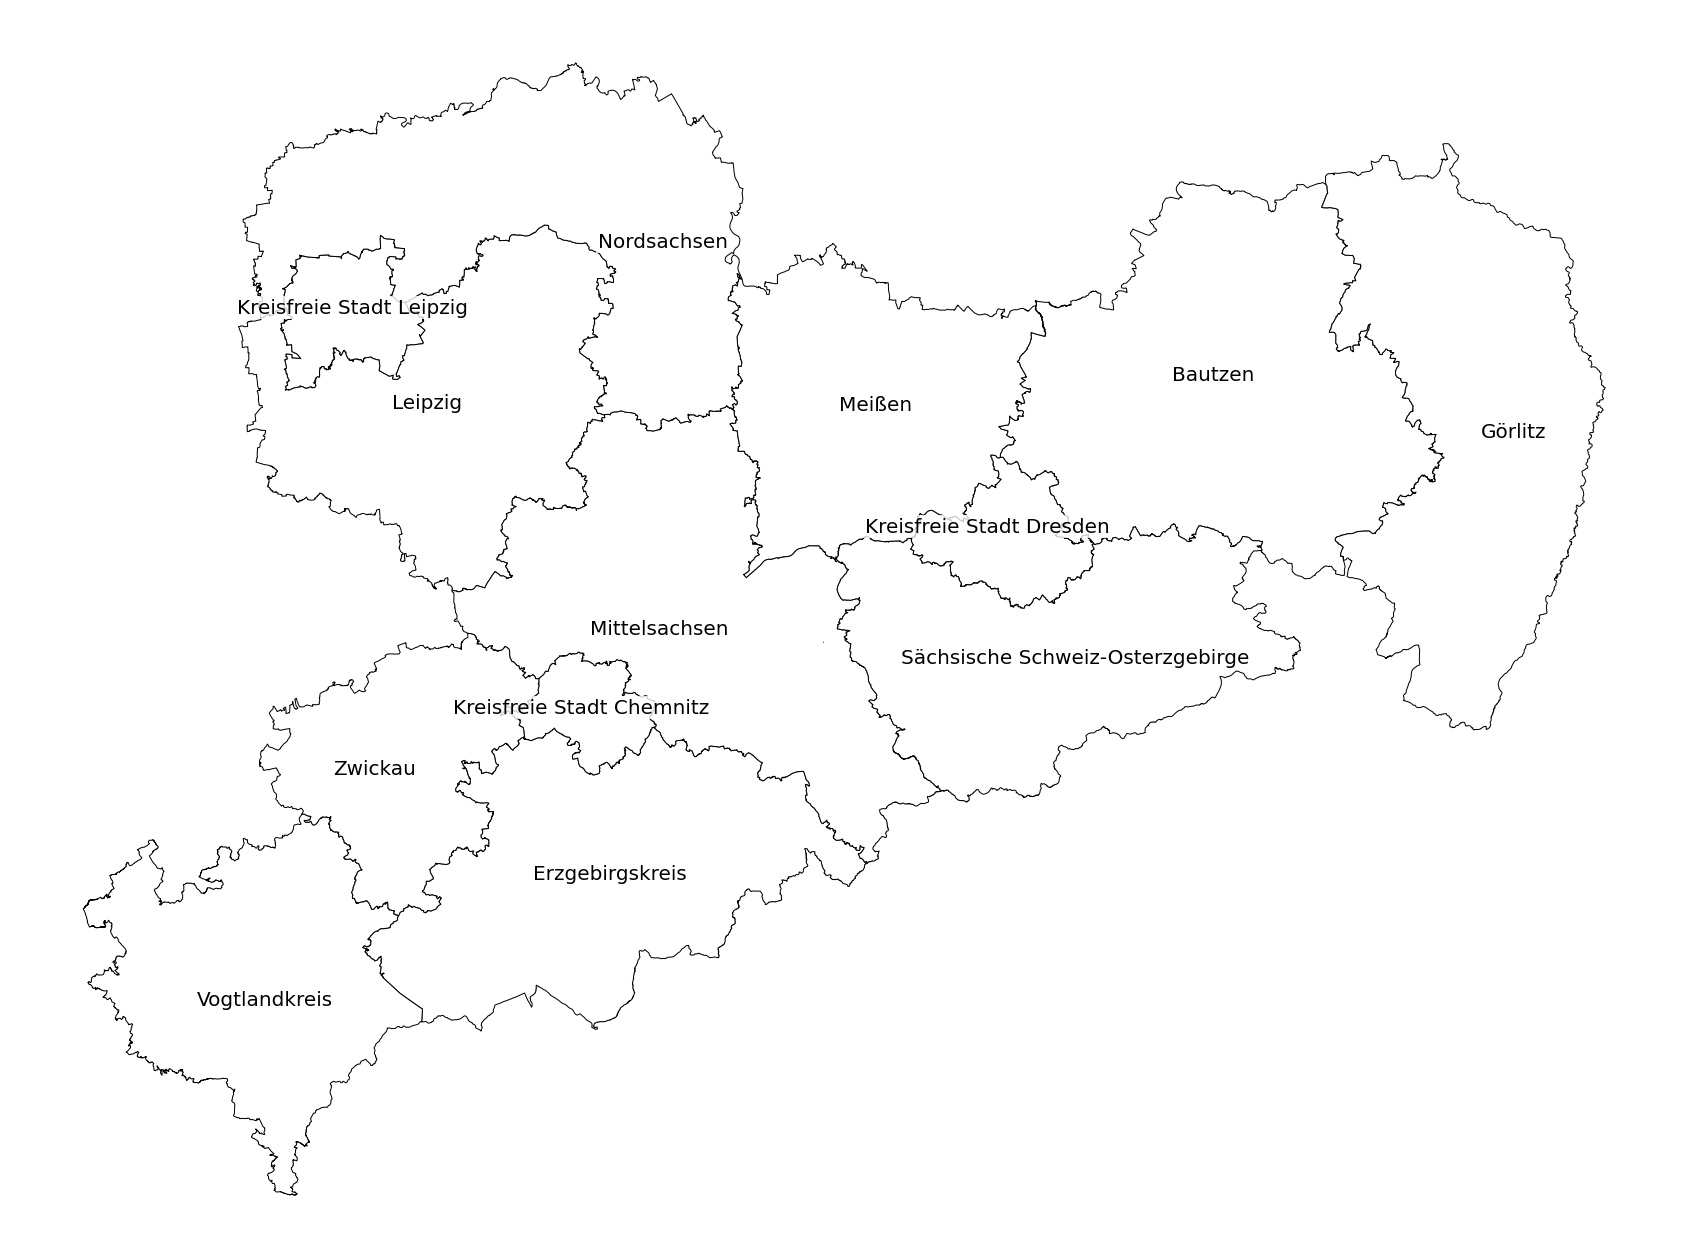

In [7]:
fig, ax = plt.subplots(figsize=(30,30))
kreis_data.plot(ax=ax, legend=True, color='white',
                edgecolor='black', linewidth=1)
for idx, row in kreis_data.iterrows():
    ax.text(row.coords[0], row.coords[1], fontsize=20,
            s=row['KREIS_NAME'], horizontalalignment='center', 
            bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})
    
plt.axis('off');

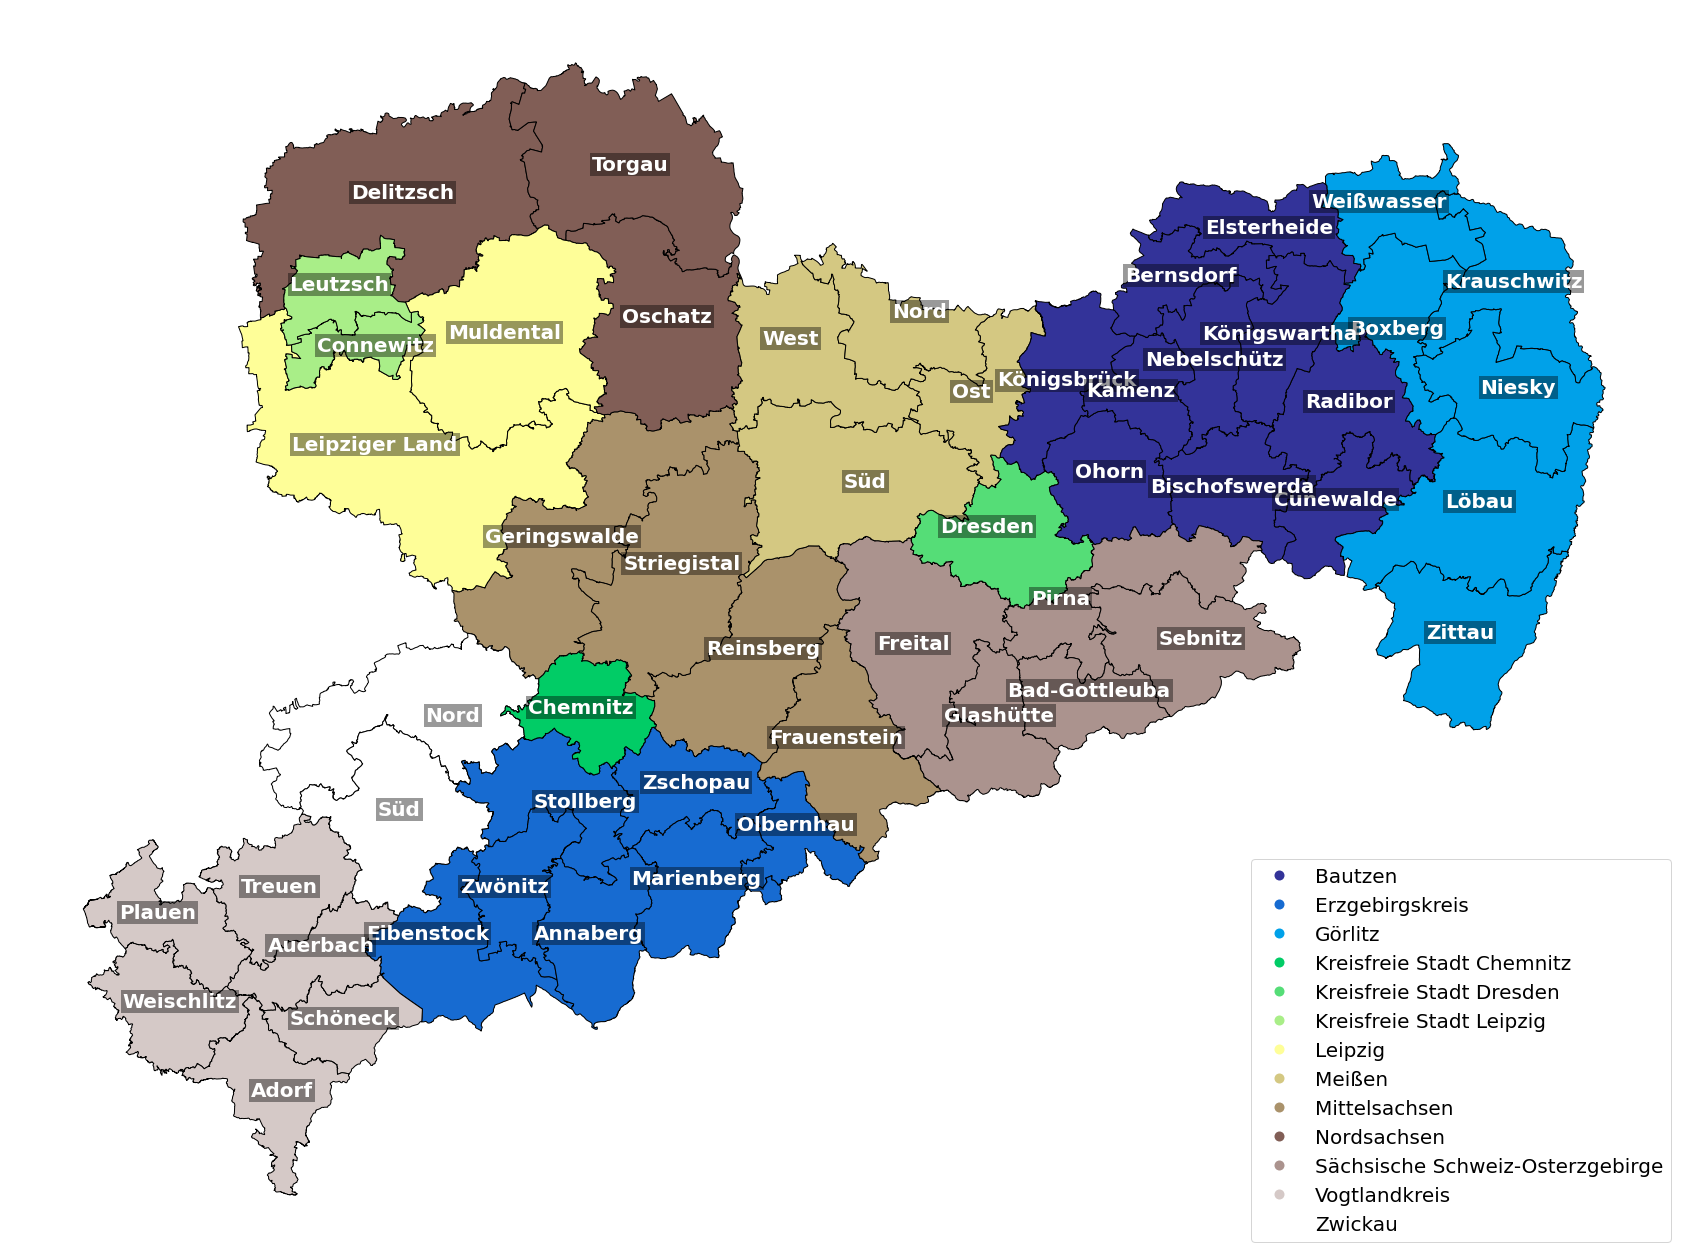

In [7]:

fig, ax = plt.subplots(figsize=(30,30))
data.plot(ax=ax, column='KREIS_NAME', legend=True,
          edgecolor='black', linewidth=1, 
          cmap='terrain', legend_kwds={'fontsize': 20, 'loc': 'lower right'})

for idx, row in data.iterrows():
    ax.text(row.coords[0], row.coords[1], color='white', weight = 'bold', fontsize=20,
            s=row['REVUFB_NM'], horizontalalignment='center', 
            bbox={'facecolor': 'black', 'alpha':0.4, 'pad': 2, 'edgecolor':'none'})
    

plt.axis('off');

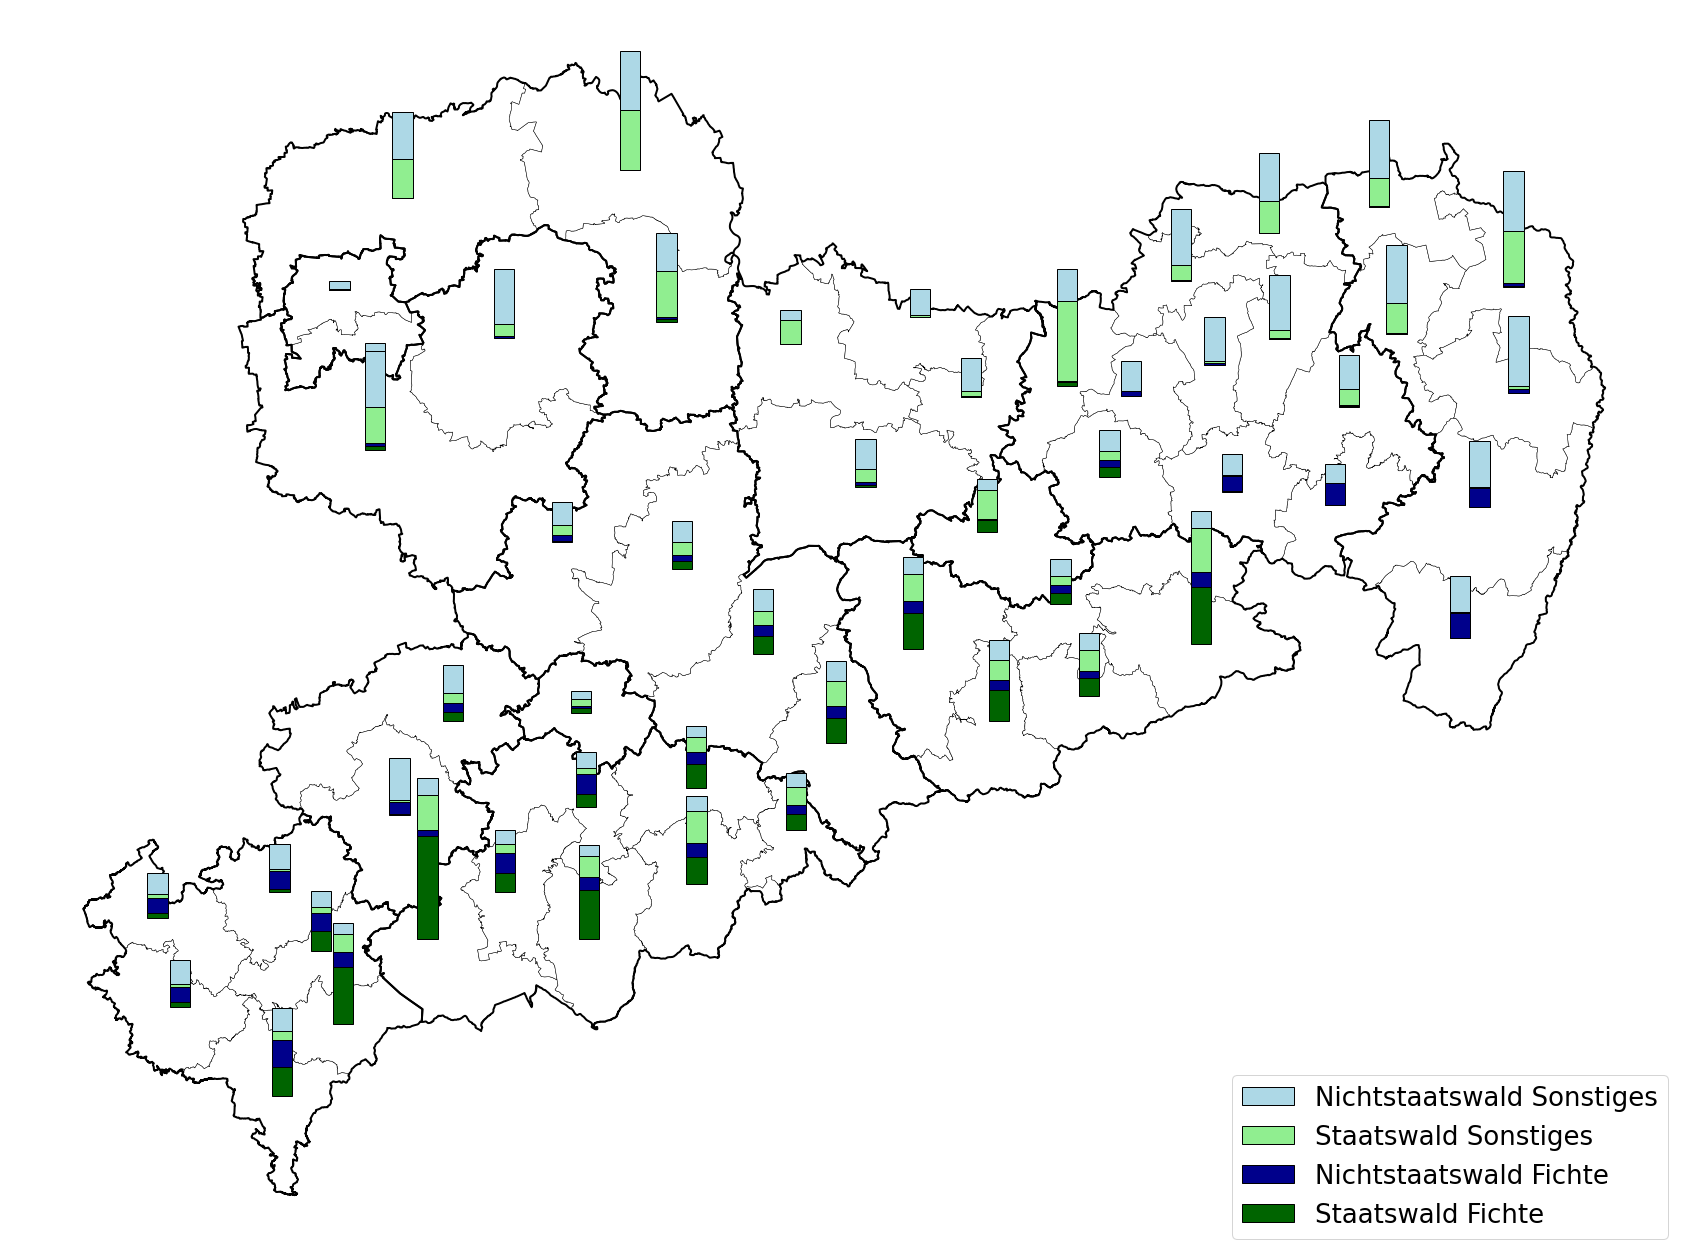

In [8]:
fig, ax = plt.subplots(figsize=(30,30))
data.plot(ax=ax, legend=True, color='white',
                edgecolor='black', linewidth=0.5)

kreis_data.plot(ax=ax, legend=True, color='none',
                edgecolor='black', linewidth=2)

width = 3000
colors = ['darkgreen', 'darkblue', 'lightgreen', 'lightblue']

for idx, row in data.iterrows():
    sw_fi = patches.Rectangle((row['coords'][0]-width/2, 
                                row['coords'][1]), 
                             width=width, height=row['SW_FI'], 
                              color=colors[0], ec='black'
                             )
    
    nsw_fi = patches.Rectangle((row['coords'][0]-width/2, 
                                   row['coords'][1] + row['SW_FI']), 
                             width=width, height=row['NSW_FI'], 
                               color=colors[1], ec='black'
                              )
    
    sw_sonst = patches.Rectangle((row['coords'][0]-width/2, 
                                   row['coords'][1] + row['SW_FI'] + row['NSW_FI']), 
                             width=width, height=row['SW_SONST'], 
                                 color=colors[2], ec='black'
                                )
    
    nsw_sonst = patches.Rectangle((row['coords'][0]-width/2, 
                                   row['coords'][1] + row['SW_FI'] + row['NSW_FI'] + row['SW_SONST']), 
                             width=width, height=row['NSW_SONST'], 
                                  color=colors[3], ec='black'
                                 )
    
    ax.add_patch(sw_fi)
    ax.add_patch(nsw_fi)
    ax.add_patch(sw_sonst)
    ax.add_patch(nsw_sonst)
    
    
plt.legend(handles=[patches.Patch(color=colors[3], label='Nichtstaatswald Sonstiges', ec='black'),
                    patches.Patch(color=colors[2], label='Staatswald Sonstiges', ec='black'),
                    patches.Patch(color=colors[1], label='Nichtstaatswald Fichte', ec='black'),
                    patches.Patch(color=colors[0], label='Staatswald Fichte', ec='black')],
          fontsize=26, loc='lower right')
plt.axis('off');

In [8]:
data_old = gpd.read_file(r'data_raw/shape/ufb_rev_vorUmstrukturierungen_.shp', encoding='utf-8')

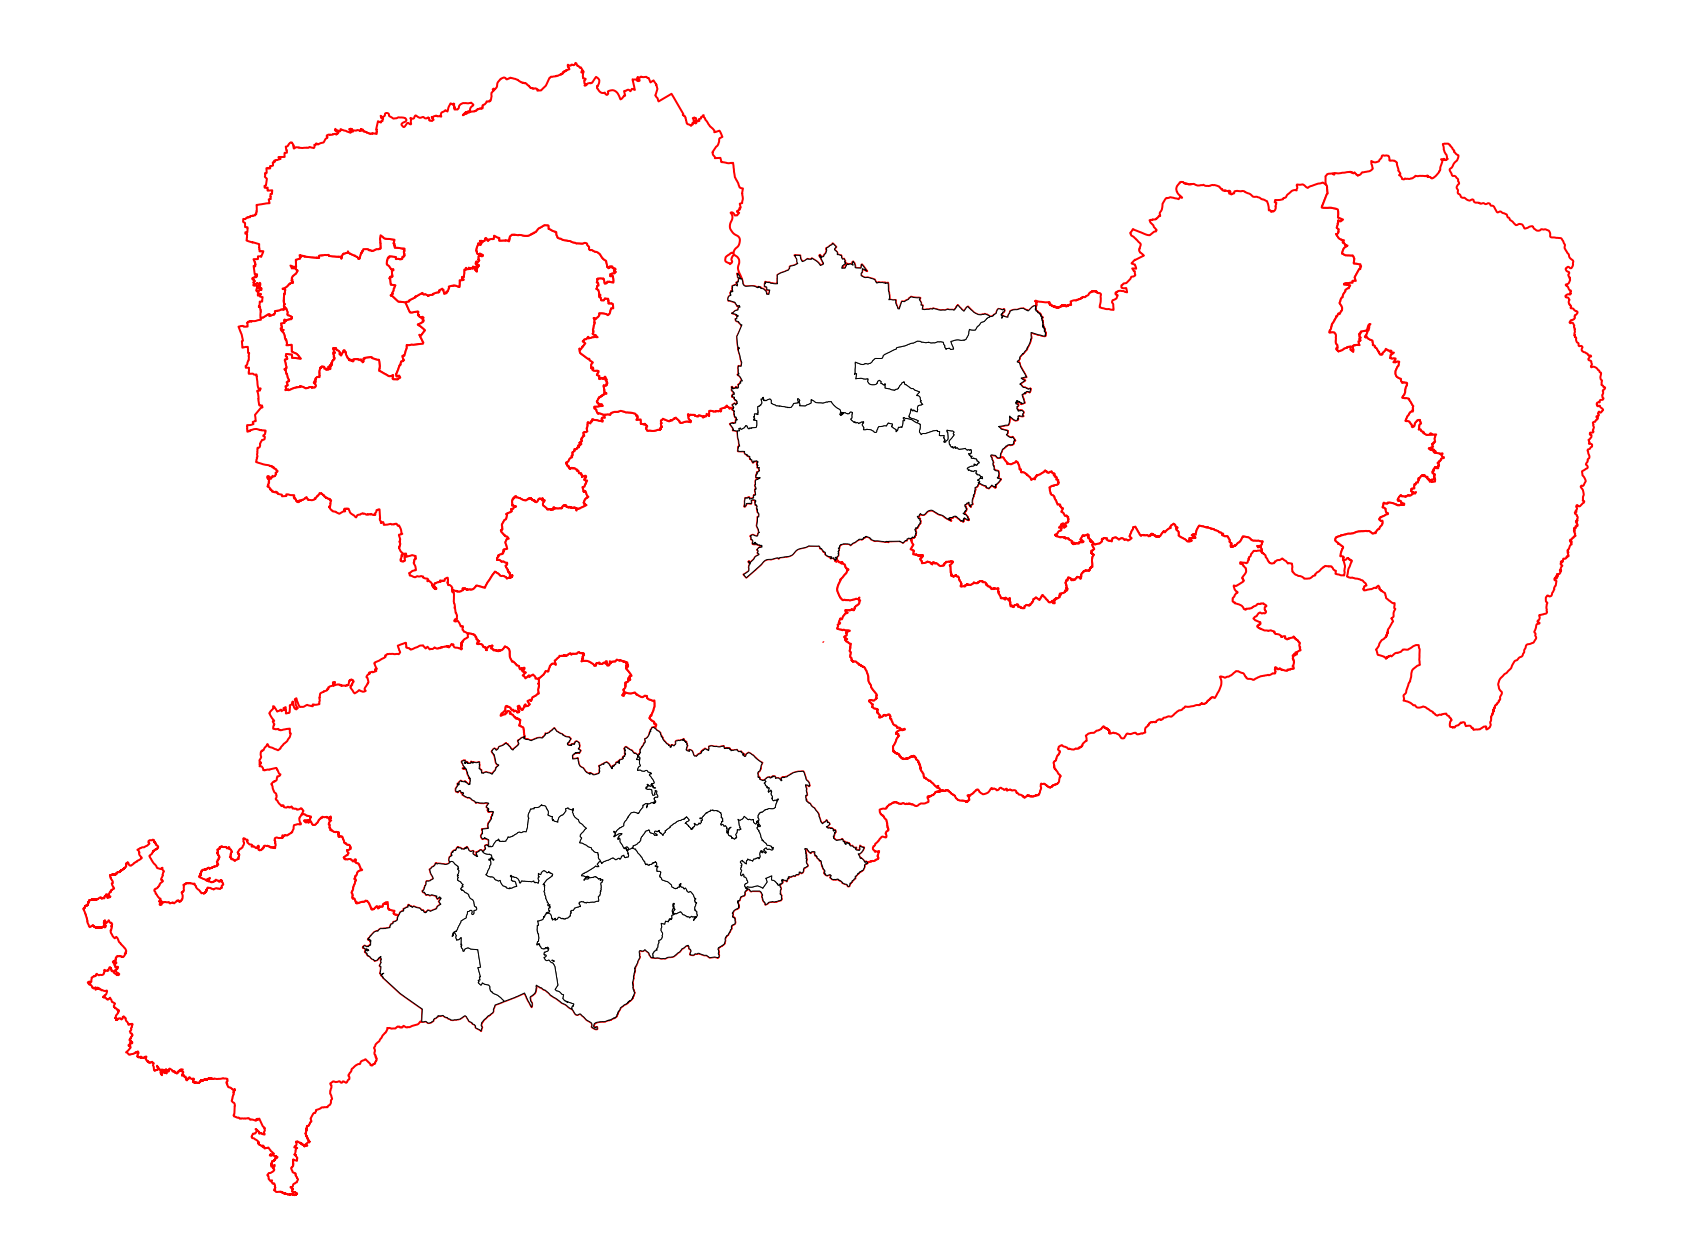

In [16]:
fig, ax = plt.subplots(figsize=(30,30))
kreis_data.plot(ax=ax, legend=True, color='white',
                edgecolor='red', linewidth=2)
data_old.plot(ax=ax, legend=True, color='white',
                edgecolor='black', linewidth=1)

plt.axis('off');

In [9]:
data.crs

{'init': 'epsg:25833'}

In [10]:
import rasterio # the GEOS-based raster package
import rasterio.plot
import rasterstats
raster = rasterio.open(r'data_raw/climate/GRID_1_Messungen_Tageswerte_2020_TM0_TW_20050315_utm.asc', nodata=-9999.0)

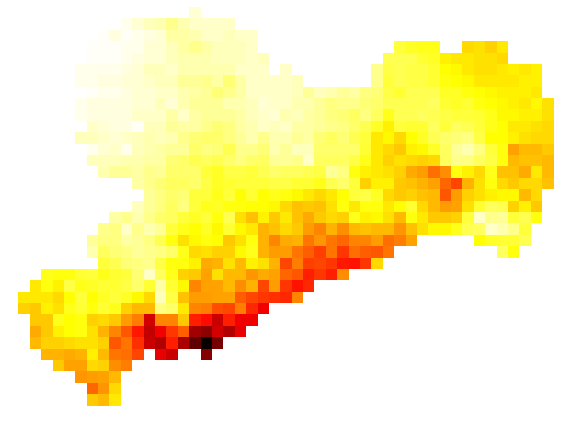

In [34]:
fig, ax = plt.subplots(figsize=(10, 15))
rasterio.plot.show(raster, cmap='hot', ax=ax)
ax.axis('off');

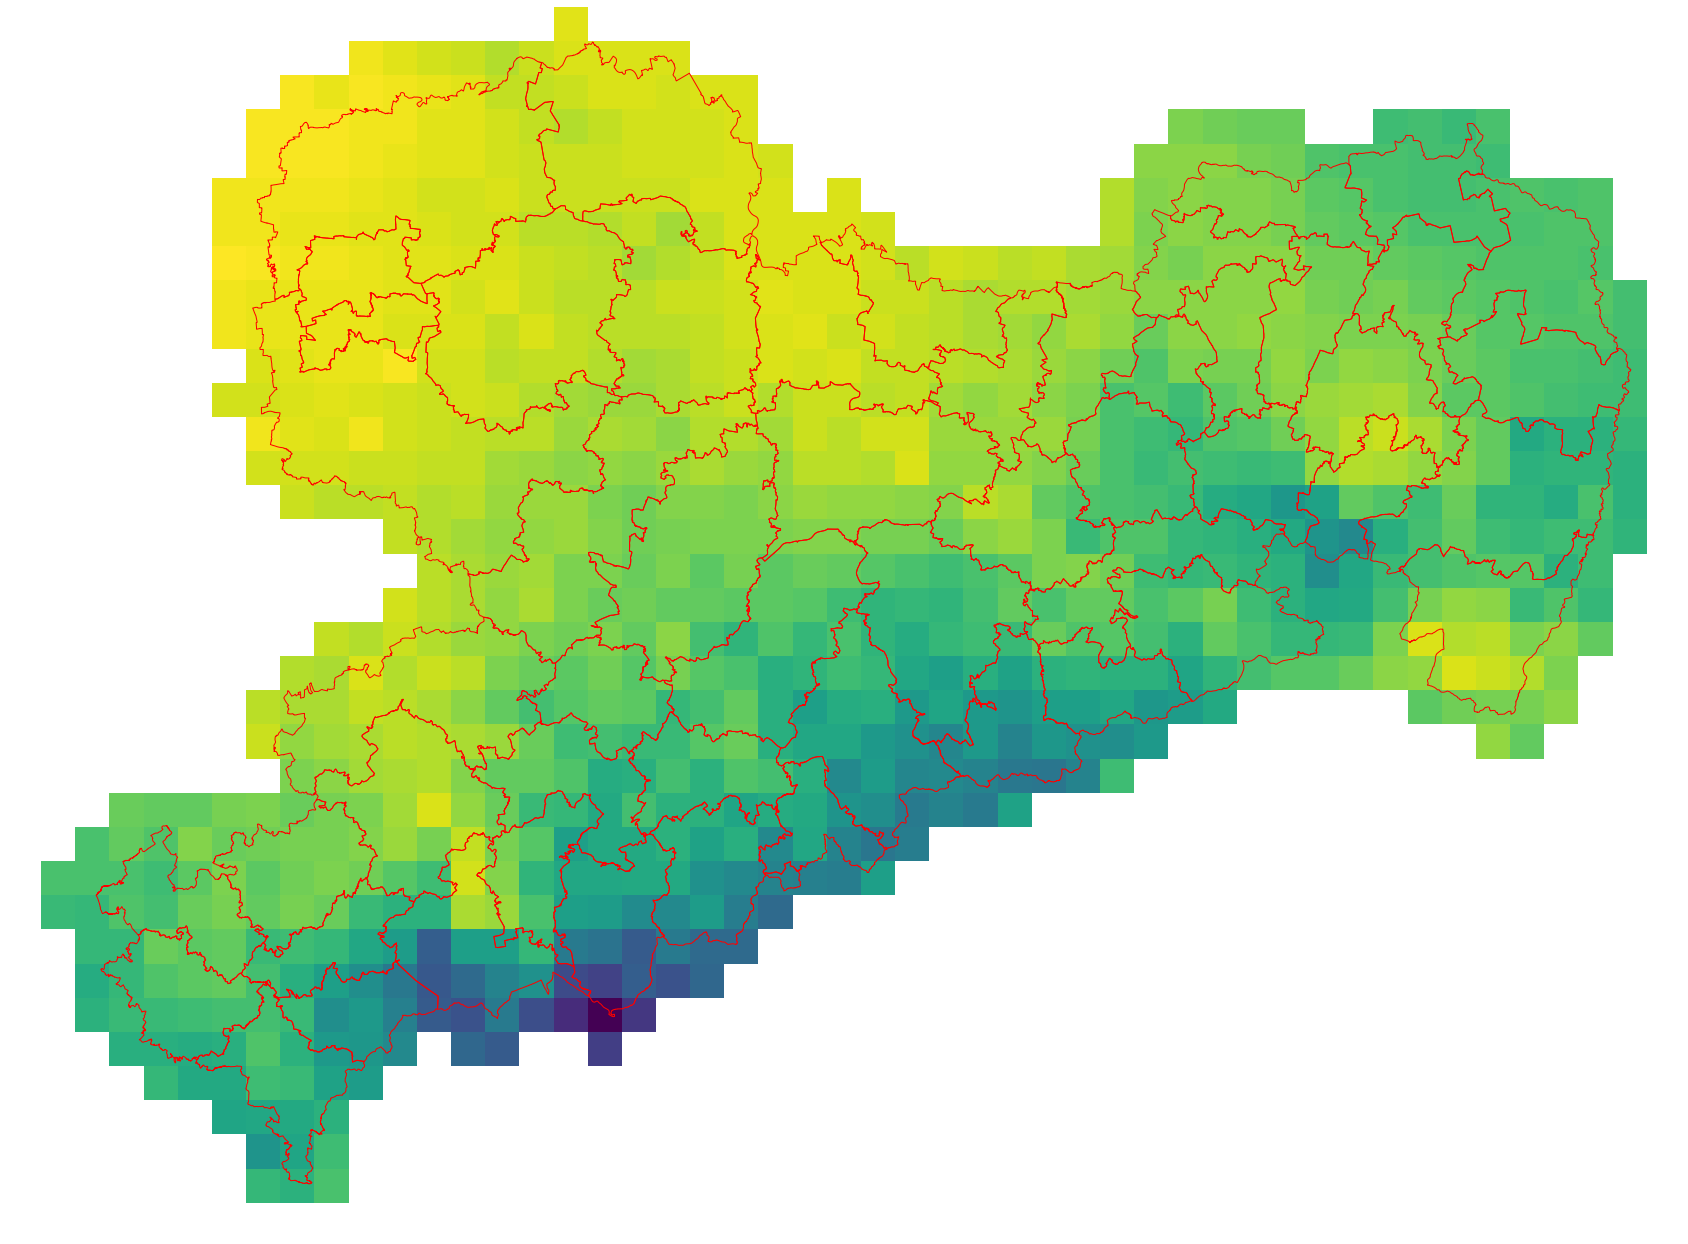

In [58]:
fig, ax = plt.subplots(figsize=(30,30))
rasterio.plot.show(raster, ax=ax)
data.plot(ax=ax, facecolor='none', edgecolor='red')
ax.axis('off');

In [13]:
adorf = data.iloc[30]

In [14]:
adorf = data[data['REVUFB_NM'] == 'Adorf']

bbox = adorf.total_bounds
window = raster.window(*bbox)
raster_adorf = raster.read(1, window=window)
raster_adorf

array([[ 4.100e+00,  4.100e+00,  3.900e+00,  2.300e+00],
       [ 3.500e+00,  4.300e+00,  3.600e+00,  2.700e+00],
       [ 3.300e+00,  4.000e+00,  3.900e+00,  3.000e+00],
       [ 3.100e+00,  3.200e+00,  3.300e+00,  3.600e+00],
       [-9.999e+03,  2.500e+00,  3.100e+00,  4.000e+00]], dtype=float32)

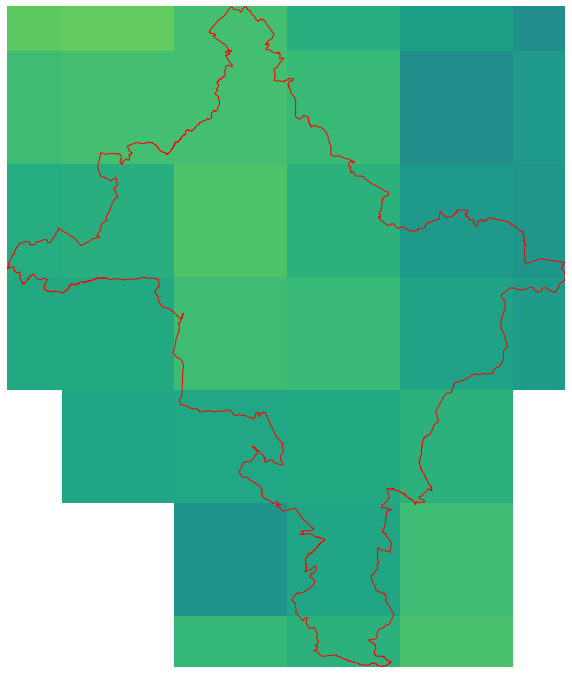

In [37]:
# nur einen Ausschnitt plotten
bbox = adorf.total_bounds

fig, ax = plt.subplots(figsize=(10,15))
rasterio.plot.show(raster, ax=ax)
adorf.plot(ax=ax, facecolor='none', edgecolor='red')

ax.set_xlim([bbox[0],  bbox[2]])
ax.set_ylim([bbox[1],  bbox[3]])

ax.axis('off');

## Zonal stats
How do we want to calculate zonal stats? Comparison of rasterstats.zonal_stats and a rasterio mask.

In [16]:
rasterband = raster.read(1)
transform = raster.transform
rasterstats.zonal_stats(adorf, rasterband, affine=transform, nodata=-9999.0, stats='mean')

[{'mean': 3.55}]

#### underfilled mask

In [17]:
from rasterio.mask import mask
masked, mask_transform = mask(dataset=raster, shapes=adorf.geometry, 
                              crop=True, # avoid loading in the whole raster
                              filled=False) # mask outside values with nodata, so we can safely compute our own stats

In [18]:
# remove one dimension from masked
print('initial shape: {}'.format(masked.shape)) # we only need the (7,6) array
masked = masked.squeeze()
print('final shape: {}'.format(masked.shape))

initial shape: (1, 7, 6)
final shape: (7, 6)


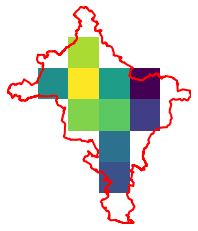

In [19]:
plt.imshow(masked.squeeze(), extent=adorf.total_bounds[[0,2,1,3]])
adorf.boundary.plot(ax=plt.gca(), color='red', linewidth=2)
plt.axis('off');

In [20]:
masked.mean()

3.55

In [21]:
np.ma.median(masked)

3.549999952316284

#### overfilled mask

In [22]:
masked, mask_transform = mask(dataset=raster, shapes=adorf.geometry, 
                              crop=True, # avoid loading in the whole raster
                              filled=False, # mask outside values with nodata, so we can safely compute our own stats
                              all_touched=True) # overfill instead of underfill
masked.mean()

3.473913109820822

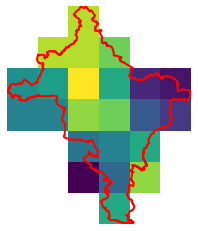

In [23]:
plt.imshow(masked.squeeze(), extent=adorf.total_bounds[[0,2,1,3]])
adorf.boundary.plot(ax=plt.gca(), color='red', linewidth=2)
plt.axis('off');

In [24]:
masked.mean()

3.473913109820822

In [25]:
np.ma.median(masked)

3.5

It seems that zonal_stats uses the underfilled mask by default to calculate the zonal statistics.

## Mass Zonal stats

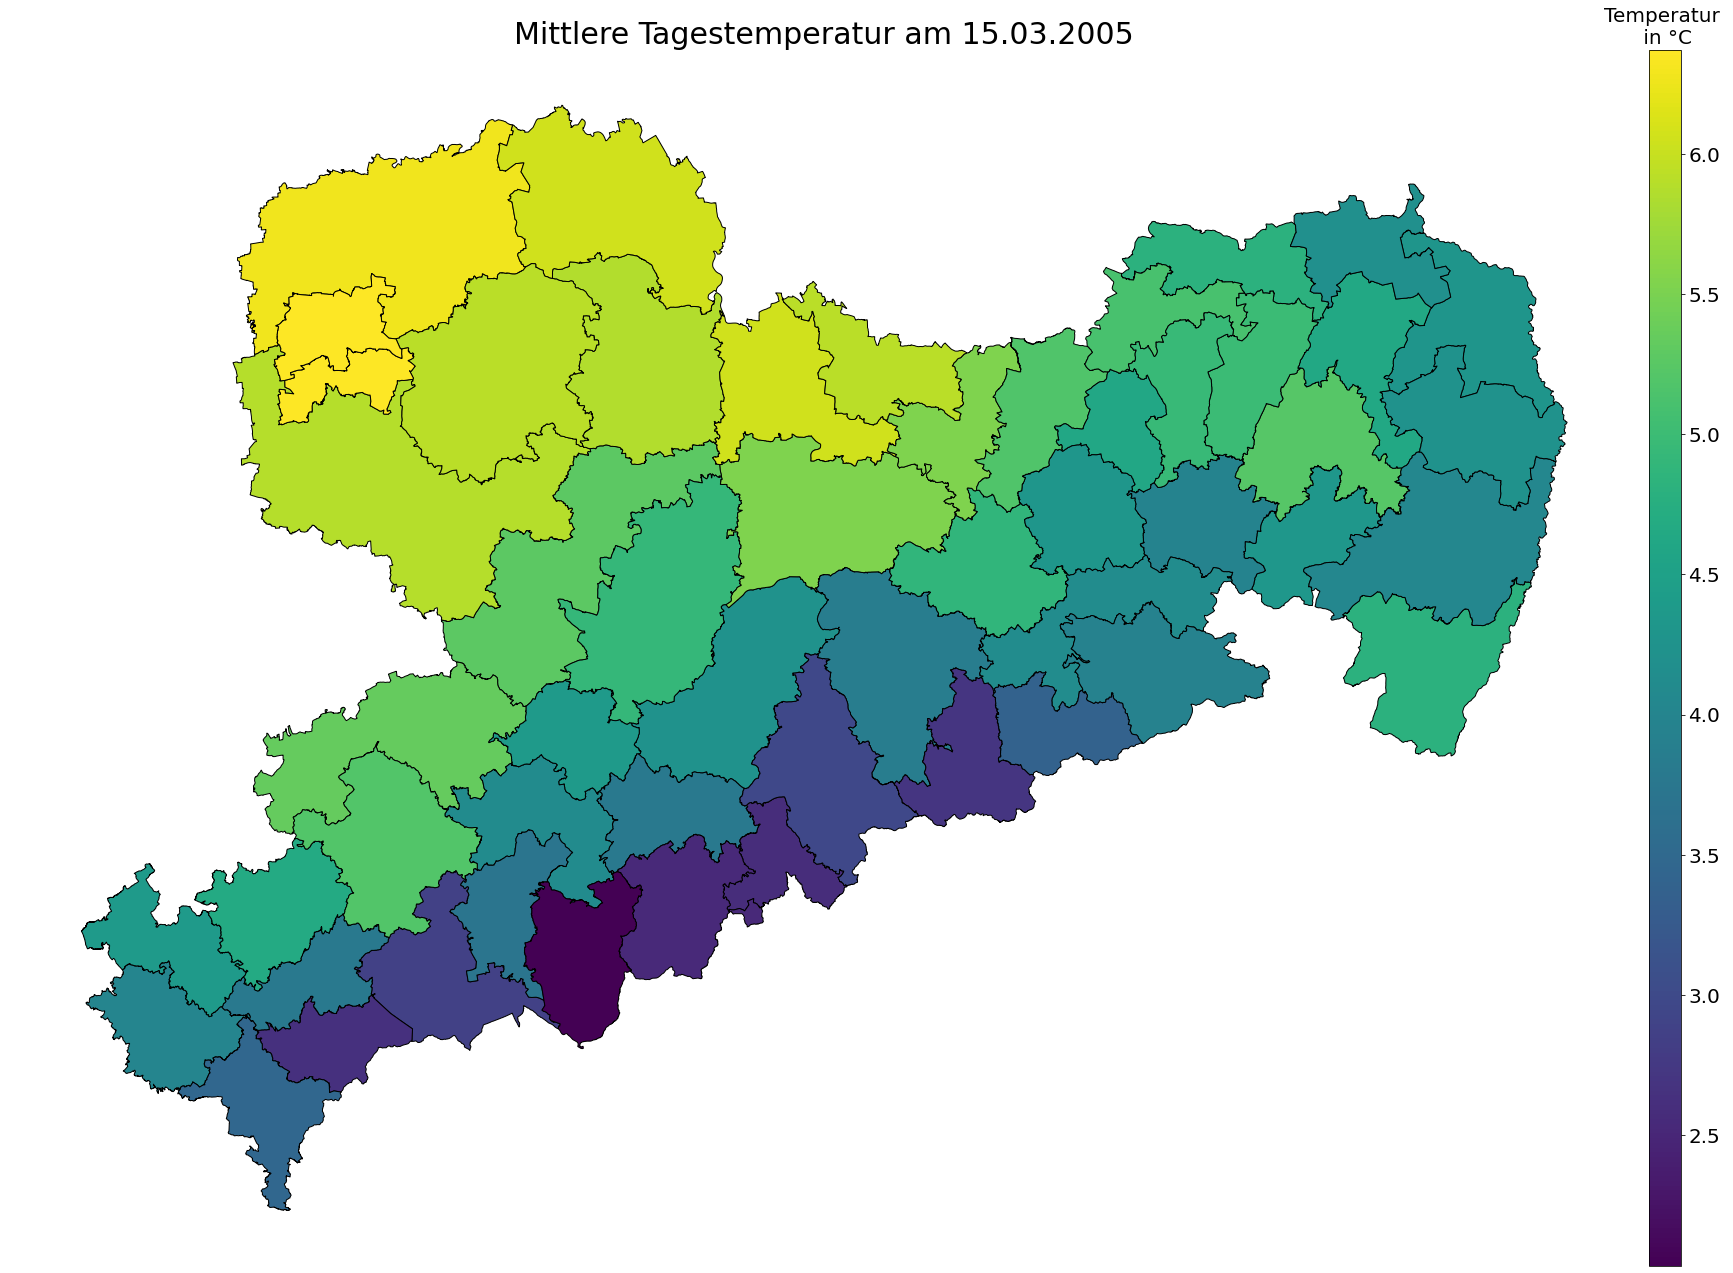

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# apply the mask and zonal stats for every forestry district, then plot the result

# define masking process
def clean_mask(geom, dataset=raster, **mask_kw):
    mask_kw.setdefault('crop', True) # only load in the raster data local to the geom 
    mask_kw.setdefault('all_touched', True) # overfill=True, underfill=False
    mask_kw.setdefault('filled', False) # mask outside values with nodata to allow computing of stats
    masked, mask_transform = mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked

# apply this mask for every forestry district

data['mean_temp'] = data.geometry.apply(clean_mask).apply(np.mean)

# plot
fig, ax = plt.subplots(figsize=(30,30))
plt.title('Mittlere Tagestemperatur am 15.03.2005', fontdict={'fontsize': 30})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
data.plot(ax=ax, column='mean_temp', edgecolor='black', 
          legend=True, 
          cax=cax)
plt.title('Temperatur \n in °C', fontdict={'fontsize': 20})
cax.tick_params(labelsize=20)
ax.axis('off');